<a href="https://colab.research.google.com/github/yunjinyong730/MLP-Classification/blob/main/MLP_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MLP를 이용한 Classification**
- 가상의 데이터 샘플들을 만들고 가상의 데이터 샘플들을 분류하는 MLP 모델을 구현하고 학습하면서 모델링과 학습 과정을 이해한다.

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs #make_blobs를 통해 가상의 데이터 만들기

%matplotlib inline

# Pseudo data 준비 : 가상의 데이터 만들기!

In [43]:
n_dim = 2

x_train, y_train = make_blobs(n_samples=200, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)
x_valid, y_valid = make_blobs(n_samples=50, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)
x_test, y_test = make_blobs(n_samples=50, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)

In [44]:
x_train[:10]

array([[-0.66771315,  0.95421609],
       [-1.75423741,  0.60417877],
       [ 0.37729635,  0.92216332],
       [-1.42150786,  1.36200632],
       [ 0.42395673,  0.63165376],
       [ 1.07117883,  1.28567353],
       [-0.90569024,  1.32467295],
       [ 0.91337122, -1.50836377],
       [ 0.6249175 ,  1.07897892],
       [-1.12313611,  0.88362451]])

In [45]:
y_train[:10]

array([3, 3, 0, 3, 0, 0, 3, 2, 0, 3])

In [46]:
# re mapping label
# classification 문제니까 클래스를 만들어주는 중...2미만은 0클래스 이상은 1클래스
y_train[y_train < 2] = 0
y_train[y_train >= 2] = 1

y_valid[y_valid < 2] = 0
y_valid[y_valid >= 2] = 1

y_test[y_test < 2] = 0
y_test[y_test >= 2] = 1

In [47]:
y_train[:10]

array([1, 1, 0, 1, 0, 0, 1, 1, 0, 1])

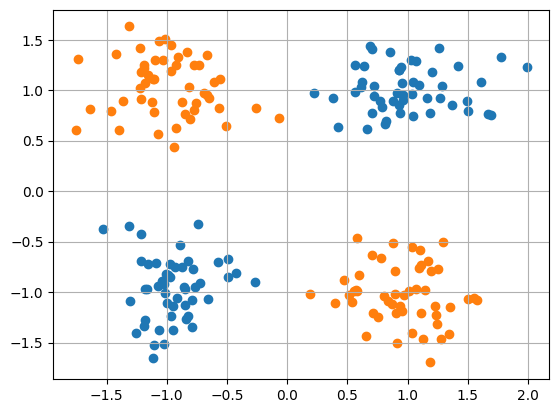

In [48]:
x_class_0 = x_train[y_train == 0]
x_class_1 = x_train[y_train == 1]

plt.scatter(x_class_0[:,0], x_class_0[:, 1])  # 모든 행에서 첫번째 열 값 == x좌표, 2번째 열 값 == y좌표
plt.scatter(x_class_1[:,0], x_class_1[:, 1])
plt.grid()

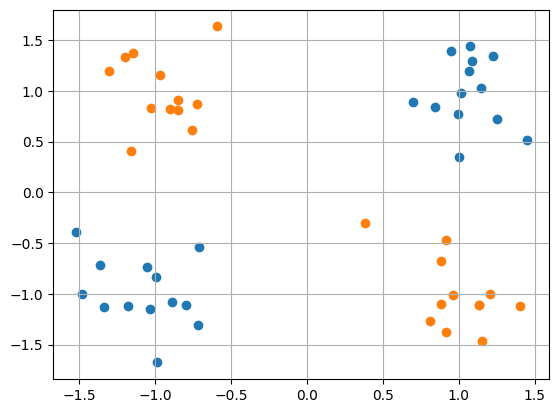

In [49]:
x_class_0 = x_test[y_test == 0]
x_class_1 = x_test[y_test == 1]

plt.scatter(x_class_0[:,0], x_class_0[:, 1])
plt.scatter(x_class_1[:,0], x_class_1[:, 1])
plt.grid()

# Dataloader: data를 로드하는 데이터 로드 구현

In [50]:
import torch
from torch.utils.data import Dataset, DataLoader #pytorch에 있는 Dataset과 DataLoader로 구현

In [51]:
class PseudoData(Dataset): # Dataset은 반드시 세 가지를 구현 - init, len, getitem
    def __init__(self, data_x, data_y=None):
        self.data_x = data_x.tolist() #np로 들어온 거 list로 바꾸기
        self.data_y = data_y
        if data_y is not None:
          self.data_y = data_y.tolist()

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, idx):
        sample = {}

        sample['x'] = self.data_x[idx] # 이것도 변수 2개인 List

        if self.data_y is not None:
            sample['y'] = self.data_y[idx]

        return sample

In [52]:
def collate_fn(batch): # batch에 샘플이 [{"x": [1,2], "y": 0}, {"x": [3,4], "y": 1}] 이런 리스트 형태로 들어옴
  # 이걸 {"x": [[1,2], [3,4]], "y": [0,1]} 이렇게 바꿔
  keys = [key for key in batch[0].keys()]
  data = {key: [] for key in keys}

  for item in batch:
        for key in keys:
            data[key].append(item[key])
  return data

In [53]:
train_dataset = PseudoData(x_train, y_train)
valid_dataset = PseudoData(x_valid, y_valid)
test_dataset = PseudoData(x_test, y_test)

# 학습 데이터셋은 shuffle을 해줘야...
train_dataloader = DataLoader(train_dataset,
                              batch_size=8,
                             collate_fn=collate_fn,
                              shuffle=True)

# valid, test set의 경우 shuffle을 할 필요 없다!
valid_dataloader = DataLoader(valid_dataset,
                              batch_size=8,
                              collate_fn=collate_fn,
                              shuffle=False)

test_dataloader = DataLoader(test_dataset,
                             batch_size=8,
                             collate_fn=collate_fn,
                             shuffle=False)

In [54]:
for batch in train_dataloader:
  print(batch)
  break

{'x': [[0.4239567325444087, 0.6316537573306902], [1.4147381959167915, 1.2349770545031753], [0.9325104016973953, 1.201593444657941], [-0.8711644944094682, 0.885479994040402], [-0.5594931299141269, 1.1132677219167766], [1.4992847541873644, -1.073460257074293], [0.8920047796409201, -0.7876341410923486], [1.6647006812989829, 0.7676643880542354]], 'y': [0, 0, 0, 1, 1, 1, 1, 0]}


#실제 MLP Model 구현

In [55]:
import torch
import torch.nn as nn
import torch.nn.init as init

# two layer 뉴런 네트워크 구현
class MLPforClassification(nn.Module):

    def __init__(self, input_dim=2, hidden_size=32, output_dim=2):
        super().__init__()
        self.linear_1 = nn.Linear(input_dim, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, output_dim)
#         self.dropout = nn.Dropout(p=0.2)
#         self.layer_norm = nn.LayerNorm(hidden_size)

        # initialize
#         torch.nn.init.xavier_uniform_(self.linear_1.weight.data)
#         torch.nn.init.xavier_uniform_(self.linear_2.weight.data)

        # better
#         self.apply(self._init_weights)
#     def _init_weights(self, m):
#         if isinstance(m, nn.Linear):
#             init.xavier_normal_(m.weight.data)
#             init.normal_(m.bias.data)


    def forward(self, x): # x: batch_size x 2(feature dimension)
        h = torch.relu(self.linear_1(x))  # batch_size x hidden_size(32)
#         h = self.dropout(h)
#         h = self.layer_norm(h)
        logit = self.linear_2(h) # batch_size x output_dim(2)

        return logit

In [56]:
model = MLPforClassification(input_dim=2, hidden_size=32, output_dim=2)

#Training

In [57]:
import torch.optim as optim
import numpy as np
from copy import deepcopy # validation 도중 best model 기록하기 위해서 : 원래는 local storage에 저장했다가 학습 이후에 꺼내쓰는데, 이번에는 메모리에 그냥 저장...

In [58]:
optimizer = optim.Adam(params=model.parameters(), lr=0.01) # 활성화 함수는 Adam 사용  Adam(Adagrad + Momentum)

In [59]:
calc_loss = nn.CrossEntropyLoss() # 손실함수는 교차 엔트로피로 구함 <- 소프트맥스로 구하는 거

In [64]:
n_epoch = 20 # 에폭은 20으로 설정 -> 데이터셋 20번 보겠다!
global_i = 0 # 전체 iteration 수

#learning curve 그리기 위해!
valid_loss_history = [] # 가중치 validation을 위한 기록 리스트 [(global_i, valid_loss), ...]
train_loss_history = []

min_valid_loss = 9e+9 # 최소 손실 값 -> 일단 최대값으로 잡아놓음
best_model = None # 가장 좋은 모델 RAM에 기록
best_epoch_i = None # 가장 좋은 모델을 어느 epoch에 봤는지 기록하기 위해

for epoch_i in range(n_epoch):
    model.train() # 훈련 가능 상태 표시하는 플래그 -> 대표적으로 드롭아웃이 이 flag에 영향을 많이 받음

    for batch in train_dataloader:
        optimizer.zero_grad()
        x = torch.tensor(batch['x'])
        y = torch.tensor(batch['y']) #y.shape: batch_size [0, 1, ...]
        y_pred = model(x) #y_pred.shape: batch_size, output_dim(2)
        loss = calc_loss(y_pred, y)

        # epoch마다 필요한 정보 logging
        if global_i % 10 == 0:
            print(f"global_i: {global_i}, epoch_i: {epoch_i}, loss: {loss.item()}")
        train_loss_history.append((global_i, loss.item()))

        loss.backward() # loss를 이용해서 기울기값 backward 오차역전으로 구하기
        optimizer.step() # optimizer.step()으로 업데이트
        global_i += 1


    model.eval() # model evalutaion을 하는 이유는 한 번의 epoch이 끝난 다음에 validation 수행

    #validation
    valid_loss_list = []
    for batch in train_dataloader:
        x = torch.tensor(batch['x'])
        y = torch.tensor(batch['y'])
        y_pred = model(x) # inference 추론 진행
        loss = calc_loss(y_pred, y) # loss 계산
        valid_loss_list.append(loss.item()) # valid_loss_list에 저장

    valid_loss_mean = np.mean(valid_loss_list)
    valid_loss_history.append((global_i, valid_loss_mean.item())) # 나중에 visualization 할 때 사용할 예정

    if valid_loss_mean < min_valid_loss: # 현재 step의 validation loss mean이 mean validation loss보다 작다면 업데이트
          min_valid_loss = valid_loss_mean
          best_epoch_i = epoch_i
          best_model = deepcopy(model)

    print("*"*30)
    print(f"valid_loss_mean: {valid_loss_mean}")
    print("*"*30)
    print(f"best_epoch_i: {best_epoch_i}")


global_i: 0, epoch_i: 0, loss: 0.026953471824526787
global_i: 10, epoch_i: 0, loss: 0.014261121861636639
global_i: 20, epoch_i: 0, loss: 0.013605400919914246
******************************
valid_loss_mean: 0.01726081285625696
******************************
best_epoch_i: 0
global_i: 30, epoch_i: 1, loss: 0.03079759143292904
global_i: 40, epoch_i: 1, loss: 0.011098727583885193
******************************
valid_loss_mean: 0.012835987959988415
******************************
best_epoch_i: 1
global_i: 50, epoch_i: 2, loss: 0.003897173097357154
global_i: 60, epoch_i: 2, loss: 0.009437603875994682
global_i: 70, epoch_i: 2, loss: 0.021562717854976654
******************************
valid_loss_mean: 0.010201835986226798
******************************
best_epoch_i: 2
global_i: 80, epoch_i: 3, loss: 0.02724887803196907
global_i: 90, epoch_i: 3, loss: 0.0033333091996610165
******************************
valid_loss_mean: 0.008578017533291132
******************************
best_epoch_i: 3
global_i:

#Learning Curve 찍어보기

Text(0, 0.5, 'loss')

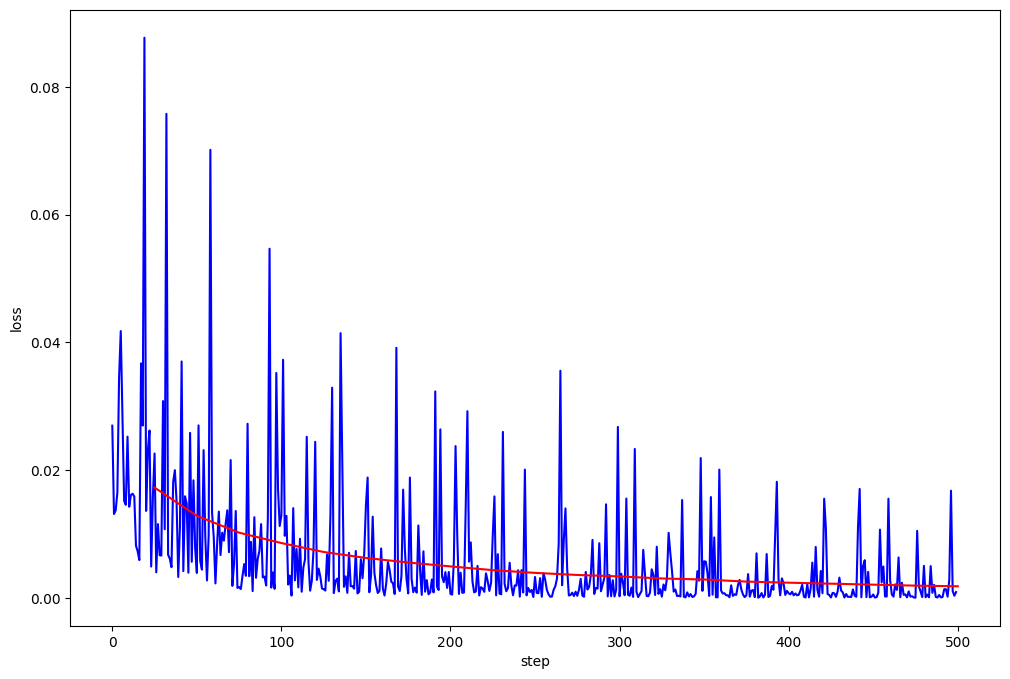

In [65]:
valid_loss_history = np.array(valid_loss_history)
train_loss_history = np.array(train_loss_history)

plt.figure(figsize=(12,8))
plt.plot(train_loss_history[:,0],
         train_loss_history[:,1], color='blue')
plt.plot(valid_loss_history[:,0],
         valid_loss_history[:,1], color='red')
plt.xlabel("step")
plt.ylabel("loss")